In [62]:
import pandas as pd 
import wandb

# api = wandb.Api()
# entity, project = "jack-morris", "emb-inv-1"  # set to your entity and project 
# runs = api.runs(entity + "/" + project) 

exp_runs = [run for run in runs if run.config.get('exp_group_name') == 'mar9-freeze']

data = []
for run in exp_runs:
    summary = {k: v for k,v in run.summary.items() if not k.startswith('gradients/')}
    obj = {**run.config, **summary}
    data.append(obj)

df = pd.DataFrame(data)

In [63]:
df.head()

,bf16,fp16,fsdp,seed,tf32,debug,optim,_n_gpu,do_eval,no_cuda,...,_step,_timestamp,eval/samples_per_second,train/global_step,train/epoch,eval/runtime,eval/perplexity,eval/bleu_score,train_text_preds,_runtime
0,True,False,,42,None,,adamw_hf,1,False,False,...,2489,1.678510e+09,31.820,216500,5.20,12.5706,53.103386,0.396739,"{'nrows': 50, 'sha256': '128958189142df241a843...",34697.246379
1,True,False,,42,None,,adamw_hf,1,False,False,...,2491,1.678542e+09,8.149,216600,5.20,49.0854,24.723958,0.477728,{'path': 'media/table/train_text_preds_2483_7d...,66240.508146
2,True,False,,42,None,,adamw_hf,1,False,False,...,2517,1.678587e+09,3.613,219000,5.26,110.7091,21.145510,0.578996,"{'_type': 'table-file', 'ncols': 2, 'nrows': 5...",112248.939187
3,True,False,,42,None,,adamw_hf,1,False,False,...,2461,1.678568e+09,3.860,214000,5.14,103.6383,1.654850,39.916899,{'_latest_artifact_path': 'wandb-client-artifa...,159814.298571
4,True,False,,42,None,,adamw_hf,1,False,False,...,2674,1.678544e+09,4.257,232500,5.58,93.9717,13.197669,7.898471,{'_latest_artifact_path': 'wandb-client-artifa...,135961.167171


In [64]:
df['embedder_fake_with_zeros'].value_counts()

True    3
Name: embedder_fake_with_zeros, dtype: int64

In [65]:
# make new value for this experiment
from typing import Dict
def embedder_exp_str(row: Dict) -> str:
    # weird - have to compare to True value or else nan will eval to True
    if row['embedder_fake_with_zeros'] == True:
        return 'Unconditional'
    elif row['embedder_no_grad']:
        return 'Reconstruct from embedding'
    else:
        return 'Input-conditioned (Autoencoder)'

df['embedder_exp'] = df.apply(embedder_exp_str, axis=1)

In [90]:
import math

df['eval/bits_per_token'] = df['eval/perplexity'].apply(math.log2)
df['eval/bits'] = df['eval/bits_per_token'] * (df['max_seq_length'] - 1)

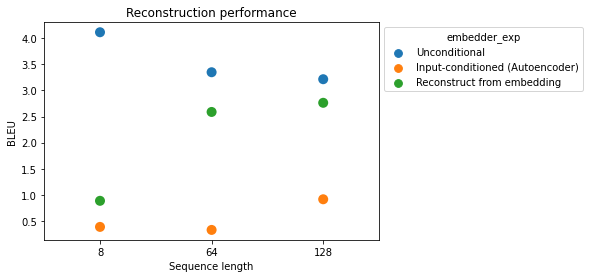

In [97]:
import seaborn as sns

ax = sns.stripplot(
    data=df, x='max_seq_length', y='train/loss', 
    hue='embedder_exp', jitter=False, size=10
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('BLEU')
# ax.set_yscale("log")
ax.set_title('Reconstruction performance')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

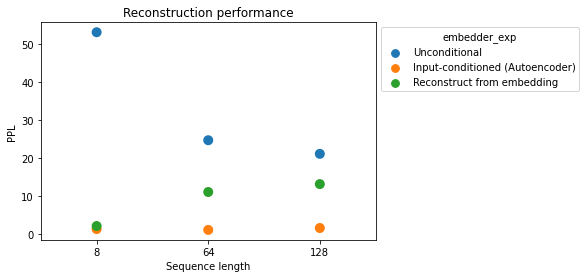

In [98]:
ax = sns.stripplot(
    data=df, x='max_seq_length', y='eval/perplexity', 
    hue='embedder_exp', jitter=False, size=10
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('PPL')
# ax.set_yscale("log")
ax.set_title('Reconstruction performance')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Text(0.5, 1.0, 'Reconstruction performance')

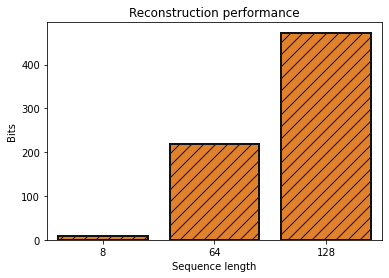

In [96]:
ax = sns.barplot(
    data=df[df['embedder_exp'] == 'Reconstruct from embedding'], 
    x='max_seq_length', y='eval/bits', 
    hatch="//",
    linewidth=2, edgecolor="#121212",
    color=sns.color_palette()[1],
    # linewidth=14,
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Bits')
# ax.set_yscale("log")
ax.set_title('Reconstruction performance')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))?

Text(0.5, 1.0, 'Reconstruction performance')

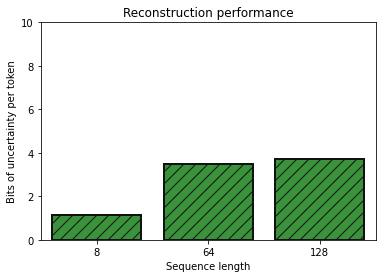

In [109]:
ax = sns.barplot(
    data=df[df['embedder_exp'] == 'Reconstruct from embedding'], 
    x='max_seq_length', y='eval/bits_per_token', 
    hatch="//",
    linewidth=2, edgecolor="#121212",
    color=sns.color_palette()[2],
    # linewidth=14,
)
ax.set_ylim([0, 10])
ax.set_xlabel('Sequence length')
ax.set_ylabel('Bits of uncertainty per token')
# ax.set_yscale("log")
ax.set_title('Reconstruction performance')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))?

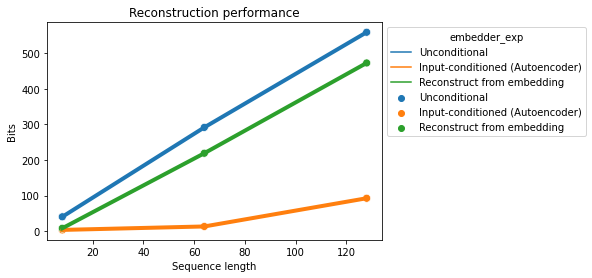

In [94]:
ax = sns.lineplot(
    data=df, x='max_seq_length', y='eval/bits', 
    hue='embedder_exp', lw=4,
)
ax = sns.scatterplot(
    data=df, x='max_seq_length', y='eval/bits', 
    hue='embedder_exp', s=64,
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Bits')
# ax.set_yscale("log")
ax.set_title('Reconstruction performance')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

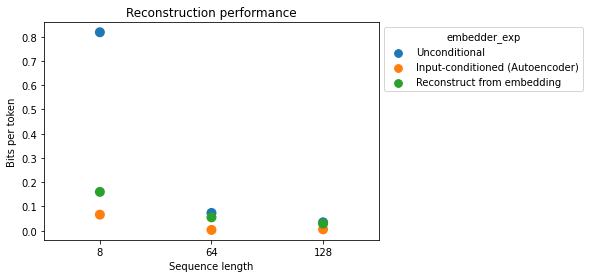

In [13]:
ax = sns.stripplot(
    data=df, x='max_seq_length', y='eval/bits_per_token', 
    hue='embedder_exp', jitter=False, size=10
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Bits per token')
# ax.set_yscale("log")
ax.set_title('Reconstruction performance')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [53]:
df['embedder_exp'].value_counts()

Unconditional                      3
Input-conditioned (Autoencoder)    3
Reconstruct from embedding         3
Name: embedder_exp, dtype: int64

Text(0.5, 1.0, 'Bits extracted from embedding')

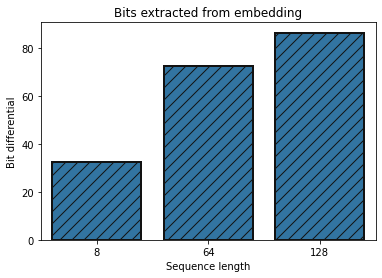

In [95]:
def bit_differential(df):
    unc = df[df['embedder_exp'] == 'Unconditional']
    assert len(unc) == 1
    unc = unc.iloc[0]
    #
    cond = df[df['embedder_exp'] == 'Reconstruct from embedding']
    assert len(cond) == 1
    cond = cond.iloc[0]
    #
    df['bit_differential'] = unc['eval/bits'] - cond['eval/bits']
    return df

bcdf = df.groupby('max_seq_length').apply(bit_differential)

# 
# 
# 

ax = sns.barplot(
    data=bcdf[bcdf['embedder_exp'] == 'Reconstruct from embedding'], 
    x='max_seq_length', y='bit_differential', 
    color=sns.color_palette()[0],
    hatch="//",
    linewidth=2, edgecolor="#121212",
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Bit differential')
# ax.set_yscale("log")
ax.set_title('Bits extracted from embedding')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))?
    